Zach Tretter

June 2020

---------

# Step 6 - Modeling

### [Data Dictionary](#Feature-Dictionary)

-----------

### [Classification](#Classification-Models) 
Predict if a GNP Campground fills up on a given day via

* Logistic Regression
* ADA Boost
* Support Vector
* Random Forest
* Neural Network
* [Model Comparision](#Classification-Model-Comparison)
    
-----------
    
### [Regression](#Regression-Models)
Predict at what time of a day a GNP Campground fills up via
* Neural Network
* Ordinary Least Squares
* Ridge
* Gamma GLM
* [Model Comparison](#Regression-Model-Comparison)
    
-------------


### [Time Series](#Time-Series-Models)

* AR
* ARMA
* SARIMAX
* Recurrent Neural Network

---------------

[Graphics used in Presentation](#GRAPHICS)

## Imports

In [220]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
from scipy import stats
import datetime

# General
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Classification
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve
import sklearn.metrics as metric
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor


# Neural Networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#### Read in the Source Data

In [2]:
df = pd.read_csv('../data/04_Full_DataFrame.csv',
                index_col = 'key_name_date')

#### Limit to Only Valid Data Points
* 'Available' denotes if a campground was open a given date
* All of 2003 is excluded due to the Roberts Fire that significantly impacted the park for most of the summer

In [3]:
df = df[(df['available']==1)
       & (df['year']!=2003)]
df.shape

(29046, 37)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29046 entries, 2000-05-01_Apga to 2019-09-30_StMa
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cg_name               29046 non-null  object 
 1   date_x                29046 non-null  object 
 2   did_fill              29046 non-null  int64  
 3   available             29046 non-null  int64  
 4   time_24               29046 non-null  object 
 5   hours_after_midnight  29046 non-null  float64
 6   year                  29046 non-null  int64  
 7   month_num             29046 non-null  int64  
 8   month_text            29046 non-null  object 
 9   day_of_year           29046 non-null  int64  
 10  day_of_month          29046 non-null  int64  
 11  weekday               29046 non-null  object 
 12  high_season           29046 non-null  int64  
 13  weekend               29046 non-null  int64  
 14  holiday               29046 non-null  int64  
 15  

---------


# Feature Dictionary

--------
|     Features     |       Grouping       | Data Type |                           Description                          | Variation Across Time | Variation across Campground |
|:----------------:|:--------------------:|:---------:|:--------------------------------------------------------------:|:---------------------:|:---------------------------:|
|    high_season   |         Date         |  Boolean  |                   1 if July or August, else 0                  |        Monthly        |             None            |
|      weekend     |         Date         |  Boolean  |                     1 if Fri or Sat, else 0                    |         Weekly        |             None            |
|      holiday     |         Date         |  Boolean  |                      1 if holiday, else 0                      |         Daily         |             None            |
|    logan_pass    |         Date         |  Boolean  |                 1 if Logan's pass open, else 0                 |         Daily         |             None            |
|        aqi       |      Air Quality     |    Int    |                    Air Quality Index by date                   |         Daily         |             None            |
|       ozone      |      Air Quality     |    Int    |                 daily avg concetration of ozone                |         Daily         |             None            |
|       PM10       |      Air Quality     |    Int    |  daily avg concentration particulate matter smaller than 10 mm |         Daily         |             None            |
|       PM25       |      Air Quality     |    Int    | daily avg concentration particulate matter smaller than 2.5 mm |         Daily         |             None            |
|      visits      |        Unique        |    Int    |                 Monthly visitors to GNP by year                |        Monthly        |             None            |
|        fee       | Campground Attribute |    Int    |             Total supply of other campground sites             |          None         |             Yes             |
|       sites      | Campground Attribute |    Int    |                  Number of sites at campground                 |          None         |             Yes             |
|   flush_toilets  | Campground Attribute |  Boolean  |                1 if campground has flush toilets               |          None         |             Yes             |
|      showers     | Campground Attribute |  Boolean  |                   1 if campground has showers                  |          None         |             Yes             |
| disposal_station | Campground Attribute |  Boolean  |              1 if campground has disposal stations             |          None         |             Yes             |
|   reservations   | Campground Attribute |  Boolean  |               1 if campground takes reservations               |          None         |             Yes             |
|        rv        | Campground Attribute |  Boolean  |                   1 if campground allows RVs                   |          None         |             Yes             |
|     primitive    | Campground Attribute |  Boolean  |                  1 if campground is primitive                  |          None         |             Yes             |
|     isolated     | Campground Attribute |  Boolean  |       1 if campground is isolated (none others close by)       |          None         |             Yes             |
|     cg_supply    |        Unique        |    Int    |             Total supply of other campground sites             |         Daily         |             None            |
|       PRCP       |        Weather       |   Float   |                  Daily precipitation (inches)                  |         Daily         |           Partial           |
|       SNOW       |        Weather       |   Float   |                     Daily snowfall (inches)                    |         Daily         |           Partial           |
|       TMAX       |        Weather       |    Int    |                      Daily temperature max                     |         Daily         |           Partial           |
|       TMIN       |        Weather       |    Int    |                      Daily temperature min                     |         Daily         |           Partial           |
|     did_PRCP     |        Weather       |  Boolean  |                       1 if rained on date                      |         Daily         |           Partial           |
|     did_Snow     |        Weather       |  Boolean  |                       1 if snowed on date                      |         Daily         |           Partial           |


### Review Features

#### Date Features

In [5]:
date_features = ['high_season',
                 'weekend',
                 'holiday',
                 'logan_pass']

#### Air Quality Features

In [6]:
air_features = ['aqi',
                'ozone',
                'PM10',
                'PM25']

#### Campground Features

In [7]:
cg_features = ['fee',
               'sites',
               'flush_toilets',
               'showers',
               'disposal_station',
               'reservations',
               'rv','primitive',
               'isolated']

cg_features_keep = ['sites',
                    'primitive',
                    'showers']

cg_features_exclude = [i for i in cg_features if i not in cg_features_keep]

In [8]:
df[cg_features_keep].corr()

,sites,primitive,showers
sites,1.000000,-0.559400,0.472593
primitive,-0.559400,1.000000,-0.271204
showers,0.472593,-0.271204,1.000000


#### Weather Features

In [9]:
wx_features = ['PRCP',
               'SNOW',
               'TMAX',
               'TMIN',
               'did_PRCP',
               'did_SNOW']

#### Final Feature Set

In [10]:
features = df.columns[12:]
features = [i for i in features if i not in cg_features_exclude]
features

['high_season',
 'weekend',
 'holiday',
 'logan_pass',
 'aqi',
 'ozone',
 'PM10',
 'PM25',
 'visits',
 'sites',
 'showers',
 'primitive',
 'cg_supply_y',
 'PRCP',
 'SNOW',
 'TMAX',
 'TMIN',
 'did_PRCP',
 'did_SNOW']

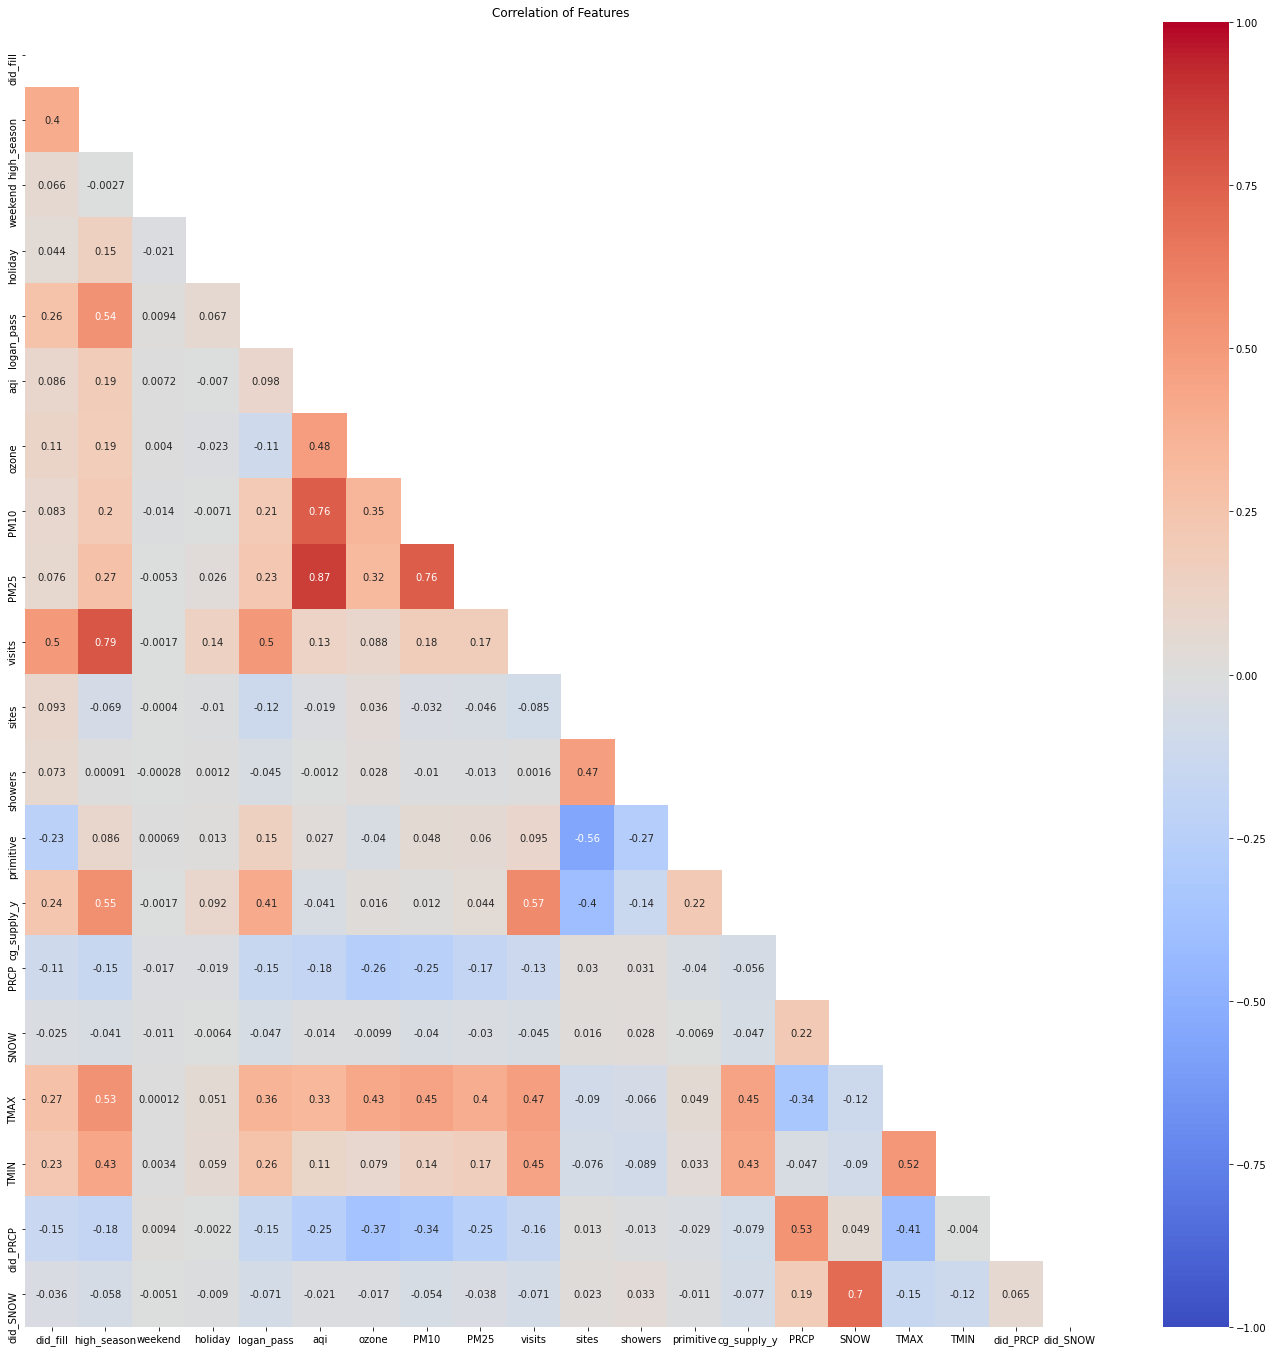

In [11]:
plt.figure(figsize=(24,24))

corr_cont = df[['did_fill'] + features].corr()

plt.title('Correlation of Features');

sns.heatmap(corr_cont,
            annot = True,
            cmap = 'coolwarm', 
            vmin = -1,
            vmax = 1,
            mask=np.triu(corr_cont));

---------



---------



----------


# Classification Models

#### Predict if a campground fills up on a given day

#### Function to Report Results by Category and Model for Classification Models

In [12]:
def Results_by_Category_Class(MODEL,
                              dataframe,
                              feature_list,
                              label_name,
                              group_on = None,
                              sort_by='Test Acc Over Baseline'):
    
    X = dataframe[feature_list]
    y = dataframe[label_name]
    
    model_name = str(MODEL).split('(')[0]
    
    # Create Empty Dictionary to record scores for each category
    grouping_scores = {}

    # Add an 'All' to reflect all data points
    if group_on != None:
        categories = [model_name] + list(dataframe[group_on].unique())
    else:
        categories = [model_name]
    
    for category in categories:
        
        # Don't know a better way to do this
        if category == model_name:
            subset_X, subset_y = X, y
        else:
            subset_X_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_X = X.loc[subset_X_indices]
            subset_y_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_y = y.loc[subset_y_indices]
        
        # Train Test Split specific to this group
        subset_X_train, subset_X_test, subset_y_train, subset_y_test = train_test_split(subset_X, subset_y,
                                                                            random_state = 111,
                                                                            stratify = subset_y)
        # Standard Scale
        sc = StandardScaler()
        subset_X_train = sc.fit_transform(subset_X_train)
        subset_X_test = sc.transform(subset_X_test)

        # Instantiate and Fit Model
        subset_model = MODEL
        subset_model.fit(subset_X_train, subset_y_train)
        
        # Generate Predictions
        subset_predictions_train = subset_model.predict(subset_X_train)
        subset_predictions_test = subset_model.predict(subset_X_test)

        # Confusion Matrix for Classification Metrics
        tn, fp, fn, tp = confusion_matrix(subset_y_test, subset_predictions_test).ravel()

        grouping_scores[category]={
            "Observations":subset_y.shape[0],
            "Incidence":subset_y.sum(),
            "Prevalence":subset_y.mean(),
            "Majority":max(subset_y.mean(),1-subset_y.mean()),
            "Train Acc":subset_model.score(subset_X_train,subset_y_train),
            "Test Acc":subset_model.score(subset_X_test,subset_y_test),
            "Test Acc Over Baseline":subset_model.score(subset_X_test,subset_y_test) - max(subset_y.mean(),1-subset_y.mean()),
#             "Train F1" :f1_score(subset_y_train, subset_predictions_train),
            "Test F1" :f1_score(subset_y_test, subset_predictions_test),
            "Sensitivity" : tp / (tp + fn),
            "Specificity" : tn / (tn + fp),
            "PPV" : tp / (tp + fp),
            "NPV" : tn / (tn + fn)
        }
           
    return np.round(pd.DataFrame(grouping_scores).T,2).sort_values([sort_by],ascending=False)

#### Specify the Dataframe for Classification

In [13]:
# To reset and undo any filters
df_class = df 

# class_filters = (df['month_num']!=5)
# df_class = df_class[class_filters]

#### Identify X and y

In [14]:
X = df_class[features]
y = df_class['did_fill']

#### Train Test Split with Stratify

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state = 111,
                                                   stratify = y)

#### Standard Scaler for Non Pipeline Models

In [16]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

### Logistic Regression Classifier

In [ ]:
logistic_c_model = LogisticRegression(
    penalty = 'l1',
    solver = 'liblinear')

logistic_c_model.fit(X_train_sc,y_train)

logistic_c_model.score(X_test_sc,y_test)

#### View Logistic Coefficients

In [ ]:
# pd.DataFrame(data=np.exp(logistic_c_model.coef_[0]),
#             columns = ['Logistic Regression Coefficient'],
#             index = features).sort_values('Logistic Regression Coefficient',
#                                           ascending=False)

### ADA Boost Classifier

In [ ]:
ada_c_model = AdaBoostClassifier(n_estimators = 150)

ada_c_model.fit(X_train_sc, y_train)

ada_c_model.score(X_test_sc,y_test)

### Support Vector Classifier

In [ ]:
svc_c_model = SVC(C = 1.0)

svc_c_model.fit(X_train_sc, y_train)

svc_c_model.score(X_test_sc,y_test)

### Random Forest Classifier

In [ ]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('rf',RandomForestClassifier())
])

params = {
    'rf__n_estimators' : [50, 100, 150],
    'rf__max_features': ['auto', 'log2'],
    'rf__max_depth': [5,10,15],
}

gs_rf_c = GridSearchCV(pipe, params,
                       cv = 5, n_jobs = 8,
                       verbose = 1)

gs_rf_c.fit(X_train, y_train)

gs_rf_c.best_params_

In [ ]:
gs_rf_c.score(X_test_sc,y_test)

## Bernoulli Naive Bayes

In [ ]:
bnb_c_model = BernoulliNB()

bnb_c_model.fit(X_train_sc, y_train)

bnb_c_model.score(X_test_sc,y_test)

### Neural Network Classifier

In [ ]:
model_NNClass = Sequential()

model_NNClass.add(Dense(32, activation = 'relu',
                        input_shape = X_train_sc[0].shape))

model_NNClass.add(Dense(8, activation = 'relu'))

model_NNClass.add(Dense(1, activation = 'sigmoid'))

model_NNClass.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics = ['accuracy'])

hist = model_NNClass.fit(X_train_sc, y_train,
                         epochs = 50,
                         batch_size= 512,
                         validation_data = (X_test_sc, y_test),
                         verbose = 0)

#### View Neural Net Loss by Epoch

In [ ]:
plt.plot(hist.history['loss'], label = 'Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()

## Classification Results by Subgroup - Campground

In [ ]:
classification_by_campground = Results_by_Category_Class(MODEL = AdaBoostClassifier(n_estimators = 150),
                                                         dataframe = df_class,
                                                         feature_list = features,
                                                         label_name = 'did_fill',
                                                         group_on = 'cg_name',
                                                         sort_by = 'Test Acc Over Baseline')

In [ ]:
classification_by_campground

## Classification Model Comparison

#### Non Neural Network Models

In [ ]:
# List out the classification models
classification_model_set = [logistic_c_model,
                           ada_c_model,
                           svc_c_model,
                           gs_rf_c.best_estimator_,
                           bnb_c_model]

# Create an emtpy dataframe
model_class_summary = pd.DataFrame()

# For each model in our list record its performance and add it to the dataframe
for i in classification_model_set:
    model_class_summary = pd.concat([model_class_summary
                                     ,Results_by_Category_Class(MODEL = i,
                                                                dataframe = df_class,
                                                                feature_list = features,
                                                                label_name = 'did_fill',
                                                                group_on = None,
                                                                sort_by = 'Test Acc Over Baseline') ]) 
# Return the dataframe
model_class_summary

#### Clean up Resultant Dataframe

In [ ]:
classification_summary = model_class_summary[
    ['Observations','Prevalence','Majority','Train Acc','Test Acc','Test Acc Over Baseline','Test F1']
].rename(index={'Pipeline':'RandomForest'})

#### Create Results for Neural Net Model (.predict vs .predict_classes)

In [ ]:
NNClass_Results = {
    "Observations":y.shape[0],
    "Prevalence":y.mean(),
    "Majority":max(y.mean(),1-y.mean()),
    'Train Acc':metric.accuracy_score(y_train,model_NNClass.predict_classes(X_train_sc)),
    'Test Acc':metric.accuracy_score(y_test,model_NNClass.predict_classes(X_test_sc)),
    'Test Acc Over Baseline':metric.accuracy_score(y_test,model_NNClass.predict_classes(X_test_sc)) - max(y.mean(),1-y.mean()),
    'Test F1':f1_score(y_test,model_NNClass.predict_classes(X_test_sc)),  
}

nnc_dict = pd.DataFrame(NNClass_Results,index=['Neural Net Classifer'])

#### Add Neural Networks to Dataframe

In [ ]:
results_df_classification = np.round(classification_summary.append(nnc_dict),2).sort_values('Test Acc Over Baseline',ascending=False)

In [ ]:
results_df_classification

## Export Tables to CSV to Format

In [ ]:
results_df_classification.to_csv("../presentation_graphics/classification_table.csv")

classification_by_campground.to_csv("../presentation_graphics/classification_table_campgroundnames.csv")

---------

---------

----------


# Regression Models

#### Predict at what time of day a campground fills up

#### Function to Report Results by Category and Model for Regression Models

In [17]:
def Results_by_Category_Reg(MODEL, dataframe, feature_list, label_name, group_on,sort_by):
    
    X = dataframe[feature_list]
    y = dataframe[label_name]
    
    model_name = str(MODEL).split('(')[0]
    
    # Create Empty Dictionary to record scores for each category
    grouping_scores = {}

    # Add an 'All' to reflect all data points
    if group_on != None:
        categories = [model_name] + list(dataframe[group_on].unique())
    else:
        categories = [model_name]
    
    for category in categories:
        
        # Don't know a better way to do this
        if category == model_name:
            subset_X, subset_y = X, y
        else:
            subset_X_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_X = X.loc[subset_X_indices]
            subset_y_indices = dataframe.loc[dataframe[group_on]==category].index
            subset_y = y.loc[subset_y_indices]
        
        # Train Test Split specific to this group
        subset_X_train, subset_X_test, subset_y_train, subset_y_test = train_test_split(subset_X, subset_y,
                                                                            random_state = 111)
        # Standard Scale
        sc = StandardScaler()
        subset_X_train = sc.fit_transform(subset_X_train)
        subset_X_test = sc.transform(subset_X_test)

        # Instantiate and Fit Model
        subset_model = MODEL
        subset_model.fit(subset_X_train, subset_y_train)
        
        # Generate Predictions
        subset_predictions_train = subset_model.predict(subset_X_train)
        subset_predictions_test = subset_model.predict(subset_X_test)

        grouping_scores[category]={
            "Observations":subset_y.shape[0],
            "Y_Bar":subset_y.mean(),
            "StdDev":subset_y.std(),
            "Train R2":metric.r2_score(subset_y_train,subset_predictions_train),
            "Test R2":metric.r2_score(subset_y_test,subset_predictions_test),
            "Train MSE":metric.mean_squared_error(subset_y_train,subset_predictions_train),
            "Test MSE":metric.mean_squared_error(subset_y_test,subset_predictions_test),
            "Train MAE":metric.mean_absolute_error(subset_y_train,subset_predictions_train),
            "Test MAE":metric.mean_absolute_error(subset_y_test,subset_predictions_test)
        }
         
    return np.round(pd.DataFrame(grouping_scores).T,2).sort_values([sort_by],ascending=False)

### Function to Plot Residuals

In [18]:
def plot_residuals(true_values, predicted_values, model_text = 'model'):
    if true_values.shape != predicted_values.shape:
        predicted_values = predicted_values.reshape(true_values.shape)
    errors = np.array(true_values) - np.array(predicted_values)
    plt.figure(figsize=(9,9))    
    plt.scatter(predicted_values, errors, s = 5)
    plt.axhline(0, color = 'red')
    plt.xlabel("Predictions", fontsize = 20)
    plt.ylabel("Residuals (Actual - Predicted)", fontsize = 20)
    plt.title(f'Residual Plot for {model_text}', fontsize = 24);
    

#### Define the dataframe of interest for Regression

In [19]:
# To reset and undo any filters
df_regress = df[df['did_fill']==1]

# regress_filters = (df_regress['month_num']!=5)

# df_regress = df_regress[regress_filters]

#### Define X and Y for Regression with suffix 'r' to denote Regression

In [20]:
Xr = df_regress[features]
yr = df_regress['hours_after_midnight']

#### Train Test Split of same

In [21]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr,
                                                   random_state = 111)

#### Standard Scaler

In [22]:
sc_reg = StandardScaler()
Xr_train_sc = sc_reg.fit_transform(Xr_train)
Xr_test_sc = sc_reg.transform(Xr_test)

### Neural Network Regression

In [ ]:
model_NNReg = Sequential()

model_NNReg.add(Dense(32, activation = 'relu',
                      input_shape = Xr_train_sc[0].shape))

model_NNReg.add(Dense(8, activation = 'relu'))

model_NNReg.add(Dense(1, activation = None))

model_NNReg.compile(loss = 'mean_squared_error',
                    optimizer = 'adam')

hist = model_NNReg.fit(Xr_train_sc, yr_train,
                       epochs = 50,
                       batch_size= 512,
                       validation_data = (Xr_test_sc, yr_test),
                       verbose = 0)

print(f'train score {metric.r2_score(yr_train,model_NNReg.predict(Xr_train_sc))}, \ntest score {metric.r2_score(yr_test,model_NNReg.predict(Xr_test_sc))}')

### Linear Regression via Sklearn

In [ ]:
linear = LinearRegression()
linear.fit(Xr_train_sc,yr_train)
print(f'train score {linear.score(Xr_train_sc,yr_train)}')
print(f'test score {linear.score(Xr_test_sc,yr_test)}')

### Ridge Regression via Sklearn

In [ ]:
ridge_model = Ridge()
ridge_model.fit(Xr_train_sc,yr_train)
print(f'train score {ridge_model.score(Xr_train_sc,yr_train)}')
print(f'test score {ridge_model.score(Xr_test_sc,yr_test)}')

### Statsmodel - Ordinary Least Squares

In [ ]:
model_X = Xr_train
model_X = sm.add_constant(model_X)
model_y = yr_train
model_OLS = sm.OLS(model_y, model_X).fit()


plot_residuals(yr_test,
               model_OLS.predict(sm.add_constant(Xr_test)),
              'Stats Model OLS')

model_OLS.summary()

## Statsmodels - Gamma Regression

In [ ]:
sm_X = Xr_train
sm_X = sm.add_constant(sm_X)
sm_y = yr_train
gamma_model = sm.GLM(sm_y, sm_X, family = sm.families.Gamma(link = sm.families.links.log)).fit()

gamma_train_preds = gamma_model.predict(sm.add_constant(Xr_train))
gamma_test_preds = gamma_model.predict(sm.add_constant(Xr_test))

plot_residuals(yr_test,
               gamma_test_preds,
              'Gamma Regression')

gamma_model.summary()

## Regression Results by Subgroup - Campground Name

In [ ]:
regression_by_campground = Results_by_Category_Reg(MODEL = SVR(),
                                                    dataframe = df_regress,
                                                    feature_list = features,
                                                    label_name = 'hours_after_midnight',
                                                    group_on = 'cg_name',
                                                    sort_by = 'Test R2')

regression_by_campground

## Regression Model Comparison

In [ ]:
regression_model_set = [LinearRegression(),
                        Ridge(alpha = 1.0),
                        SVR(),
                        AdaBoostRegressor(n_estimators = 100),
                        KNeighborsRegressor(),
                        model_NNReg]

model_comparison = pd.DataFrame()

for i in regression_model_set:
    model_comparison = pd.concat([model_comparison,
                              Results_by_Category_Reg(MODEL = i,
                                dataframe = df_regress,
                                feature_list = features,
                                label_name = 'hours_after_midnight',
                                group_on = None,
                                sort_by = 'Test R2') ])


#### Create same Metrics for Gamma GLM (Statsmodel instead of Sklearn)

In [ ]:
gamma_report = {
    "Observations":yr.shape[0],
    "Y_Bar":yr.mean(),
    "StdDev":yr.std(),
    "Train R2":metric.r2_score(yr_train,gamma_train_preds),
    "Test R2":metric.r2_score(yr_test,gamma_test_preds),
    "Train MSE":metric.mean_squared_error(yr_train,gamma_train_preds),
    "Test MSE":metric.mean_squared_error(yr_test,gamma_test_preds),
    "Train MAE":metric.mean_absolute_error(yr_train,gamma_train_preds),
    "Test MAE":metric.mean_absolute_error(yr_test,gamma_test_preds)
}

gamma_report_df = np.round(pd.DataFrame(gamma_report,index=['Gamma GLM']),2)

#### Add Gamma to Summary Report

In [ ]:
regression_summary = model_comparison.append(
    gamma_report_df).sort_values(
    'Test R2',ascending=False)

In [ ]:
regression_summary = regression_summary.rename(
    index={[i for i in list(regression_summary.index) if 'tensor' in i][0]:"Neural Net Regressor"}
)[list(gamma_report.keys())]

In [ ]:
regression_summary

## Export Tables to CSV to Format

In [ ]:
regression_summary.to_csv("../presentation_graphics/regression_table.csv")

regression_by_campground.to_csv("../presentation_graphics/regression_table_campgroundnames.csv")

------------

-----------

----------

# Visualize Results at a Single Campground

#### Identify the subgroup of interest

In [95]:
subgroup = (df_regress['cg_name'] == 'Rising Sun') # & (df_regress['year']==2016)

# Create X and Y specific to that subgroupd and train-test-split
X = df_regress.loc[subgroup, features]
y = df_regress.loc[subgroup, 'hours_after_midnight']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=111)

# Standard Scaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
X_sc = sc.transform(X)

#### Support Vector Regression

In [96]:
svr = SVR()
svr.fit(X_train_sc, y_train)
preds_svr = svr.predict(X_sc)

print(f'train score {svr.score(X_train_sc,y_train)}')
print(f'test score {svr.score(X_test_sc,y_test)}')

train score 0.5768296483593452
test score 0.5181463046532087


#### Gamma Regression

In [97]:
sm_X = X_train
sm_X = sm.add_constant(sm_X)
sm_y = y_train
gamma_model = sm.GLM(sm_y, sm_X, family = sm.families.Gamma(link = sm.families.links.log)).fit()

gamma_train_preds = gamma_model.predict(sm.add_constant(X_train))
gamma_test_preds = gamma_model.predict(sm.add_constant(X_test))
preds_gamma = gamma_model.predict(sm.add_constant(X))

print(f'train score {metric.r2_score(y_train,gamma_train_preds)}')
print(f'test score {metric.r2_score(y_test,gamma_test_preds)}')

train score 0.5410476897541794
test score 0.5010531201881003


C:\Users\zacha\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


#### Create Dataframe to view these Predictions

In [213]:
df_subgroup = df_regress.loc[subgroup,:].copy()
df_subgroup['svr_predictions'] = preds_svr
df_subgroup['gamma_predictions'] = preds_gamma
df_subgroup['actual_fill_time'] = df_subgroup['hours_after_midnight']

df_subgroup['date_x'] = pd.to_datetime(df_subgroup['date_x'])
df_subgroup.set_index('date_x',inplace=True)

#### The Plot

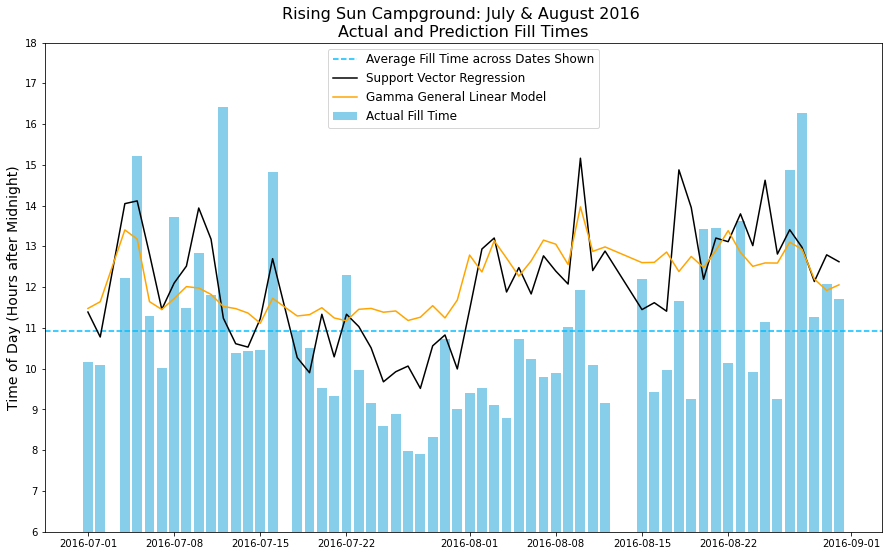

In [224]:
year_filter = 2016

df_to_plot = df_subgroup.loc[
    (df_subgroup['year']==year_filter)
    & (df_subgroup['high_season']==1),
    ['actual_fill_time','svr_predictions','gamma_predictions']]

plt.figure(figsize=(15,9))
plt.title(f'Rising Sun Campground: July & August {year_filter} \nActual and Prediction Fill Times',fontsize = 16)
plt.ylabel('Time of Day (Hours after Midnight)',fontsize = 14)

plt.bar(x = df_to_plot.index, height = df_to_plot['actual_fill_time'],
       label = 'Actual Fill Time',
       color = 'skyblue')

# plt.plot(df_to_plot['actual_fill_time'],
#          label = 'Actual Fill Time',
#          color = 'skyblue')

plt.axhline(df_to_plot['actual_fill_time'].mean(), ls='--',
           label = 'Average Fill Time across Dates Shown',
           color = 'deepskyblue')

plt.plot(df_to_plot['svr_predictions'],
         label = 'Support Vector Regression',
         color = 'black')

plt.plot(df_to_plot['gamma_predictions'],
        label = 'Gamma General Linear Model',
        color = 'orange')

plt.yticks(range(6,19))
plt.ylim(6,18)

plt.xticks()





plt.legend(fontsize = 12)


In [47]:
df_subgroup

,cg_name,did_fill,available,time_24,hours_after_midnight,year,month_num,month_text,day_of_year,day_of_month,...,cg_supply_y,PRCP,SNOW,TMAX,TMIN,did_PRCP,did_SNOW,Support Vector Regression,Gamma Regression,actual_fill_time
date_x,,,,,,,,,,,,,,,,,,,,,
2000-07-01,Rising Sun,1,1,16:21,16.35,2000,7,Jul,183,1,...,928,0.0,0.0,76.0,43.0,0,0,17.889762,17.702813,16.35
2000-07-02,Rising Sun,1,1,17:45,17.75,2000,7,Jul,184,2,...,928,0.0,0.0,69.0,42.0,0,0,17.986262,17.655392,17.75
2000-07-08,Rising Sun,1,1,19:45,19.75,2000,7,Jul,190,8,...,928,0.0,0.0,75.0,38.0,0,0,16.940440,17.560893,19.75
2000-07-09,Rising Sun,1,1,17:40,17.67,2000,7,Jul,191,9,...,928,0.0,0.0,72.0,42.0,0,0,17.289738,17.585789,17.67
2000-07-10,Rising Sun,1,1,17:45,17.75,2000,7,Jul,192,10,...,928,0.0,0.0,70.0,40.0,0,0,17.861106,17.725103,17.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-17,Rising Sun,1,1,11:32,11.53,2019,8,Aug,229,17,...,928,0.3,0.0,62.0,40.0,1,0,13.723955,12.398720,11.53
2019-08-18,Rising Sun,1,1,11:08,11.13,2019,8,Aug,230,18,...,928,0.1,0.0,74.0,50.0,1,0,10.952041,12.148403,11.13
2019-08-19,Rising Sun,1,1,09:56,9.93,2019,8,Aug,231,19,...,928,0.0,0.0,78.0,47.0,0,0,10.607372,12.037251,9.93


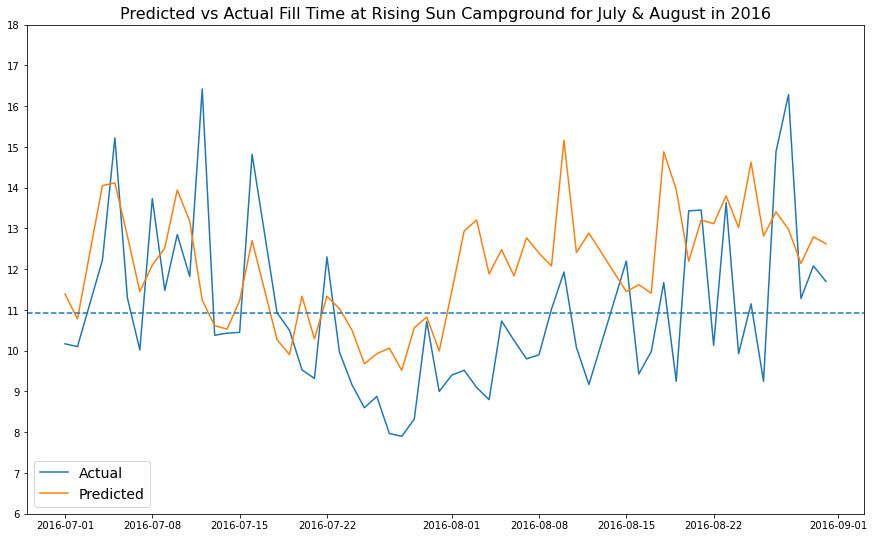

# Time Series Models (TBD)

-------------

# Graphics

--------

### Graphic for AQI at Many Glacier September 2017

In [ ]:
extract_to_plot = df.loc[(df['cg_name']=='Many Glacier')
                         & (df['month_num']==9)
                         & (df['year']==2017)
                         & (df['day_of_month']<15)].set_index('day_of_month')['aqi']
plt.figure(figsize=(12,8))


plt.plot(extract_to_plot,
        color = 'black',
        lw = 4)

plt.xlabel('Day of Month in September 2017',fontsize=16)
plt.ylabel('Daily Air Quality Level',fontsize=16)
plt.title('Air Quality Index Levels in Flathead County',fontsize=20)

plt.axhspan(0,50,color='green',)
plt.axhspan(50,100,color='yellow')
plt.axhspan(100,150,color='orange')
plt.axhspan(150,200,color='red')
plt.axhspan(200,300,color='purple')

plt.xticks(np.arange(1,15,1))
plt.yticks(np.arange(0,325,25));


### Graphic for Annual Visitors vs Fill Days

In [ ]:
yearly_visits = df.loc[(df['cg_name']=='Apgar') & (df['day_of_month']==1)].groupby('year')['visits'].sum()
yearly_fills = df.groupby('year')['did_fill'].mean()
the_corr = np.round(np.corrcoef(yearly_visits,yearly_fills)[0][1],2)

fig_dims = (15,9)
fig, ax1 = plt.subplots(figsize = fig_dims)

ax2 = ax1.twinx()
ax2.plot(yearly_visits,color = 'red')
ax1.plot(yearly_fills)

ax2.set_yticks(range(0,3_000_001,300_000))
ax1.set_yticks(np.round([0.1*i for i in range(0,11)],2))

ax2.set_ylabel('Total GNP Annual Visitors (Millions)',fontsize = 14,color = 'red')
ax1.set_ylabel('Total GNP Campground Fills / Total GNP Available Campground Days',fontsize = 14,color='blue')
ax1.set_xticks(range(2000,2020))

plt.grid()
ax1.set_facecolor(color = 'whitesmoke')

plt.title(f'Campground Demand vs Visitors in Glacier National Park \n Correlation of {the_corr} from 2000 to 2019',fontsize = 24);


### Graphic for Fill Time Distribution

In [ ]:
series_to_plot = df_regress['hours_after_midnight']

fig_dims = (15,9)

fig,ax = plt.subplots(1,2,
                     figsize = fig_dims)

sns.distplot(series_to_plot, ax = ax[0])
sns.distplot(np.log(series_to_plot), ax = ax[1])

ax[0].set_ylabel('Unit Space',fontsize = 16)
ax[1].set_ylabel('Log Space',fontsize = 16)
ax[0].set_xlabel('Hours after Midnight')
ax[1].set_xlabel('Log of Hours after Midnight');

### Air Quality Plot to Identify Prominent Fires

In [ ]:
daily_air_quality = df.loc[df['cg_name']=='Apgar',['date_x','aqi']]

daily_air_quality['date_x']=pd.to_datetime(daily_air_quality['date_x'])

daily_air_quality.set_index('date_x',inplace=True)

plt.figure(figsize=(16,12))

plt.plot(daily_air_quality.resample('M').mean());